In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [60]:
df = pd.read_csv("Dataset Forcasting.csv")
stats = df.describe()
print(df.head())


   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [62]:
Q1 = stats["Weekly_Sales"][4]
Q3 = stats["Weekly_Sales"][6]
df2 = df[(df["Weekly_Sales"] >= Q1 - 1.5*(Q3 - Q1)) & (df["Weekly_Sales"] <= Q3 + 1.5*(Q3 - Q1))]
print(df2.shape)


(6401, 8)


C:\Users\cabro\AppData\Local\Temp\ipykernel_125228\3629451001.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q1 = stats["Weekly_Sales"][4]
C:\Users\cabro\AppData\Local\Temp\ipykernel_125228\3629451001.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q3 = stats["Weekly_Sales"][6]


In [65]:
print((df2.duplicated() == True).sum())

0


In [87]:
df_arima = df[["Date", "Weekly_Sales"]]
df_arima["Date"] = pd.to_datetime(df_arima["Date"], infer_datetime_format=True, format='mixed')
print(df_arima["Date"].max().year)

2012


C:\Users\cabro\AppData\Local\Temp\ipykernel_125228\3907841452.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_arima["Date"] = pd.to_datetime(df_arima["Date"], infer_datetime_format=True, format='mixed')
C:\Users\cabro\AppData\Local\Temp\ipykernel_125228\3907841452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arima["Date"] = pd.to_datetime(df_arima["Date"], infer_datetime_format=True, format='mixed')


In [128]:
year_sales = []
month = []
for i in range (2010,2013):
    year_sale = []
    for k in range (1,13):
        for j in range (len(df_arima["Date"])):
            if (df_arima.iloc[j]["Date"].year == i) & (df_arima.iloc[j]["Date"].month == k):
                year_sale.append(df_arima.iloc[j]["Weekly_Sales"])
        year_sales.append(sum(year_sale))
        month.append("-".join((str(k),str(i))))
df_new = pd.DataFrame({"Month" : month, "Monthly_Sales" : year_sales})
df_new.set_index("Month", inplace=True)

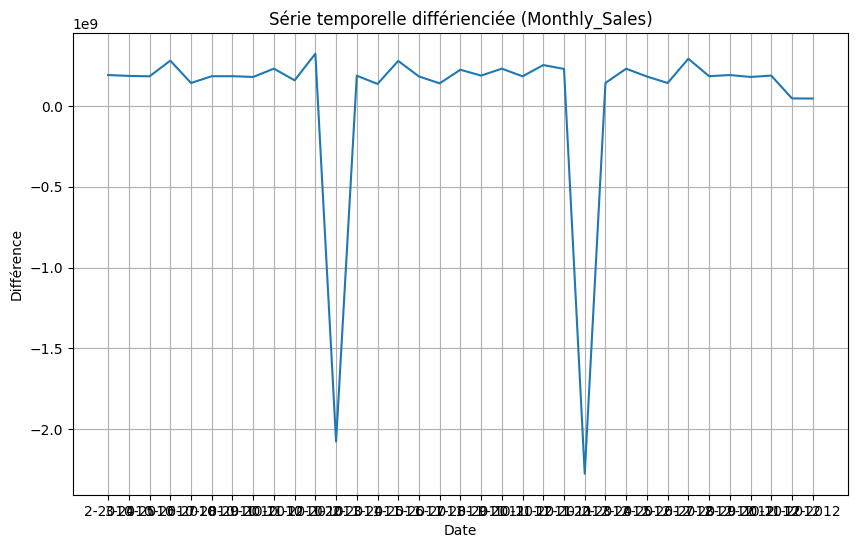

In [145]:

differenced = df_new['Monthly_Sales'].diff().dropna()

# Afficher la série différienciée
plt.figure(figsize=(10, 6))
plt.plot(differenced)
plt.title('Série temporelle différienciée (Monthly_Sales)')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

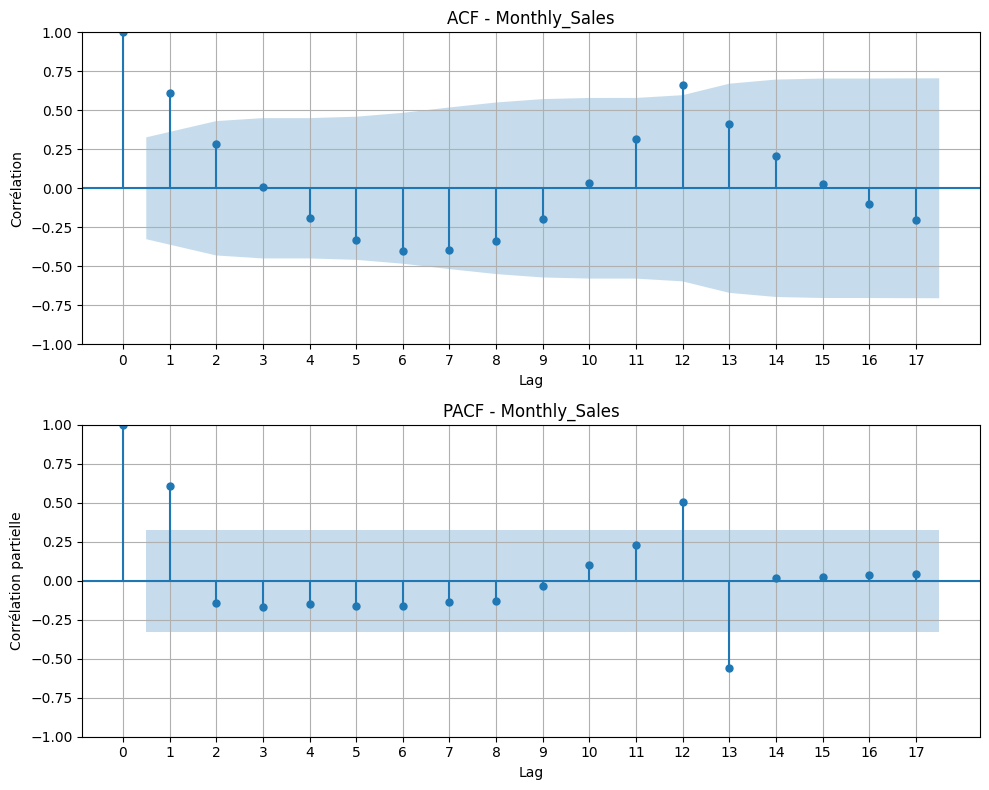

In [151]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_new["Monthly_Sales"], lags=17, zero=True, ax=ax1)
ax1.set_title('ACF - Monthly_Sales')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

ax1.set_xticks(np.arange(0, 18, 1))

plot_pacf(df_new["Monthly_Sales"], lags=17, zero=True, ax=ax2)
ax2.set_title('PACF - Monthly_Sales')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

ax2.set_xticks(np.arange(0, 18, 1))

plt.tight_layout()

plt.show()

p = 1, d = 1, q = 1

In [152]:
result = adfuller(df_new["Monthly_Sales"])
table = [["valeur de test", result[0]], ["p-valeur", result[1]],["conclusion", "La série est stationnaire" if result[1] < 0.05 else "La série n'est pas stationnaire"]]
print(tabulate(table, headers=["Métrique", "Valeur"]))

Métrique        Valeur
--------------  -------------------------
valeur de test  -4.327125898182919
p-valeur        0.0003985434642094735
conclusion      La série est stationnaire


In [ ]:
train_data = df_new["Monthly_Sales"][:-6]
test_data = df_new["Monthly_Sales"][-6:]
model = ARIMA(train_data, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing 

                               SARIMAX Results                                
Dep. Variable:          Monthly_Sales   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -626.454
Date:                Tue, 25 Feb 2025   AIC                           1258.907
Time:                        17:25:31   BIC                           1263.009
Sample:                    01-01-2010   HQIC                          1260.192
                         - 06-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6829      0.534      1.279      0.201      -0.364       1.730
ma.L1         -0.9581      0.389     -2.465      0.014      -1.720      -0.196
sigma2      4.055e+17   5.22e-19   7.77e+35      0.0

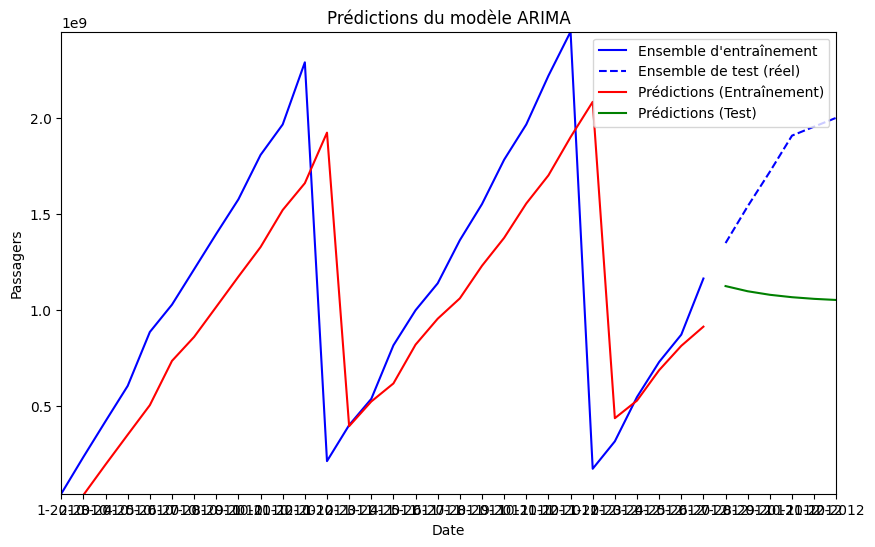

In [164]:
# Prédictions sur l'ensemble d'entraînement
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Tracer les prédictions et les données réelles avec les courbes collées
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Ensemble d\'entraînement', color='blue')
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(train_data.index, train_predictions, label='Prédictions (Entraînement)', color='red')
plt.plot(test_data.index, test_predictions, label='Prédictions (Test)', color='green')

# Définir les limites des axes x et y pour une continuité visuelle
plt.xlim(train_data.index[0], test_data.index[-1])
plt.ylim(min(train_data.min(), test_data.min()), max(train_data.max(), test_data.max()))

plt.xlabel('Date')
plt.ylabel('Passagers')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

In [ ]:
# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train_data, train_predictions)
train_mse = mean_squared_error(train_data, train_predictions)
train_rmse = mean_squared_error(train_data, train_predictions)
train_r2 = r2_score(train_data, train_predictions)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_data, test_predictions)
test_mse = mean_squared_error(test_data, test_predictions)
test_rmse = mean_squared_error(test_data, test_predictions)
test_r2 = r2_score(test_data, test_predictions)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
import pmdarima as pm

# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = df_new["Monthly_Sales"][:-6]
test_data = df_new["Monthly_Sales"][-6:]

# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
model = pm.auto_arima(train_data)

print(model.summary())

C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -646.343
Date:                Tue, 25 Feb 2025   AIC                           1298.686
Time:                        17:28:05   BIC                           1302.890
Sample:                    01-01-2010   HQIC                          1300.031
                         - 06-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.003e+08   2.14e-11   2.34e+19      0.000       5e+08       5e+08
ar.L1          0.5458      0.044     12.363      0.000       0.459       0.632
sigma2      2.803e+17   3.48e-20   8.06e+36      0.0

C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

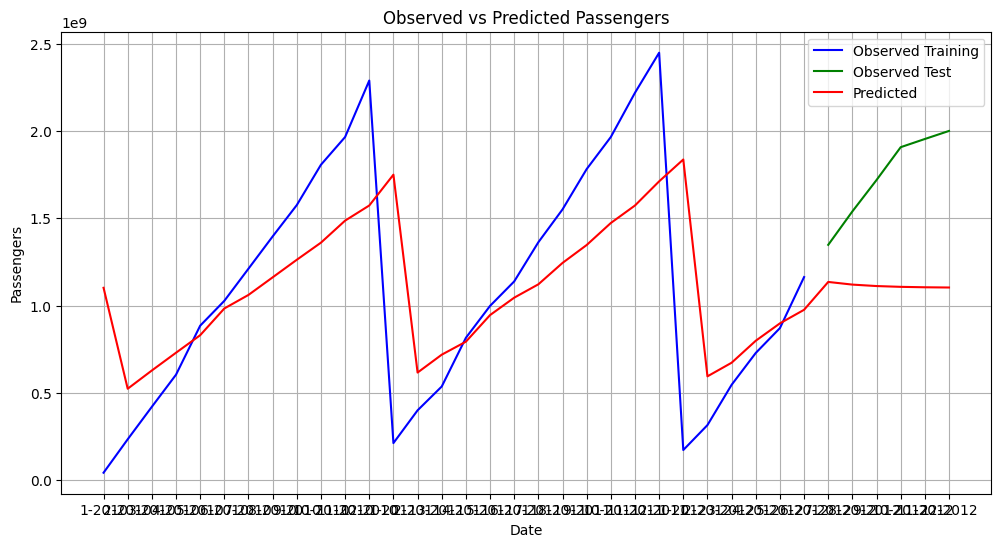

In [167]:
model.fit(train_data)
# Faire des prédictions sur l'ensemble d'entraînement
train_pred, train_confint = model.predict_in_sample(return_conf_int=True)

# Faire des prédictions sur l'ensemble de test
n_periods = len(test_data)
predicted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Concaténer les prédictions pour l'ensemble d'entraînement et de test
all_predictions = pd.concat([pd.Series(train_pred, index=train_data.index), 
                             pd.Series(predicted, index=test_data.index)], 
                            axis=0)

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Observed Training', color='blue')
plt.plot(test_data, label='Observed Test', color='green')
plt.plot(all_predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Observed vs Predicted Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [168]:
# Calculer les mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train_data, train_pred)
train_mse = mean_squared_error(train_data, train_pred)
train_rmse = mean_squared_error(train_data, train_pred)
train_r2 = r2_score(train_data, train_pred)

# Calculer les mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_data, predicted)
test_mse = mean_squared_error(test_data, predicted)
test_rmse = mean_squared_error(test_data, predicted)
test_r2 = r2_score(test_data, predicted)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)


  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE             3.812323e+08      6.309357e+08
1      MSE             3.097303e+17      4.593342e+17
2     RMSE             3.097303e+17      4.593342e+17
3       R²             3.284739e-01     -7.202245e+00
